In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
!pip install lime
!pip install pytorch-gradcam -q
!pip install keras-grad-cam matplotlib

ERROR: Could not find a version that satisfies the requirement keras-grad-cam (from versions: none)
ERROR: No matching distribution found for keras-grad-cam


In [3]:
pip install pillow scikit-image lime shap opencv-python matplotlib tensorflow


Note: you may need to restart the kernel to use updated packages.


In [4]:
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import lime
from lime import lime_image
import shap
from tensorflow.keras.applications import VGG16  # Replace with your pre-trained model if not VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2  # Import cv2 for image processing
from matplotlib import pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from skimage.transform import resize
from tensorflow.keras.models import Model

In [9]:
dataset_dir = r"/Users/prajwal/Documents/TB_Chest_Radiography_Database"
normal_dir = os.path.join(dataset_dir, "Normal")
tuberculosis_dir = os.path.join(dataset_dir, "Tuberculosis")

In [10]:
def preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            try:
                image = Image.open(image_path)
                image = image.convert("RGB")       # Convert grayscale to RGB
                image = image.resize((256, 256))   # Resize images to 256x256 pixels
                image = np.array(image) / 255.0    # Normalize pixel values to [0, 1]
                images.append(image)
                labels.append(label)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
    return images, labels

In [11]:
# Load and preprocess normal images
normal_images, normal_labels = preprocess_images(normal_dir, label=0)

In [12]:
# Load and preprocess tuberculosis images
tuberculosis_images, tuberculosis_labels = preprocess_images(tuberculosis_dir, label=1)

In [13]:
# Combine normal and tuberculosis images
images = normal_images + tuberculosis_images
labels = normal_labels + tuberculosis_labels

In [14]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [15]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [16]:
# Check the shape of the training and testing sets
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (3360, 256, 256, 3)
Test images shape: (840, 256, 256, 3)
Train labels shape: (3360,)
Test labels shape: (840,)


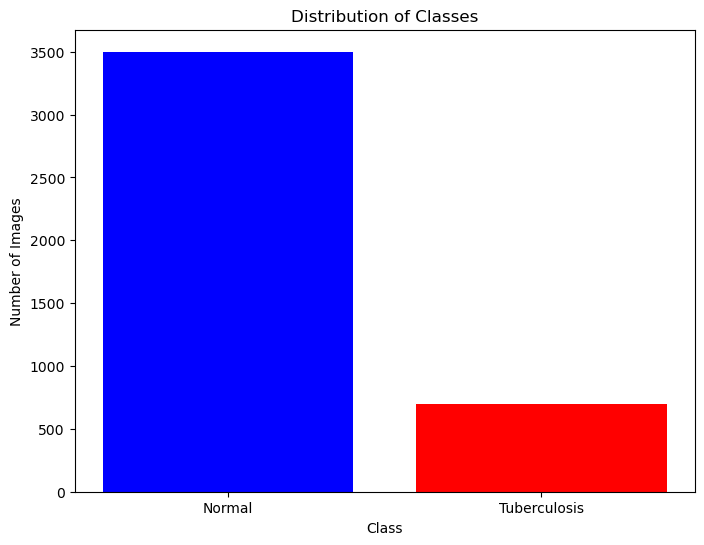

In [17]:
# Visualize the distribution of classes
plt.figure(figsize=(8, 6))
plt.bar(["Normal", "Tuberculosis"], [len(normal_images), len(tuberculosis_images)], color=['blue', 'red'])
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

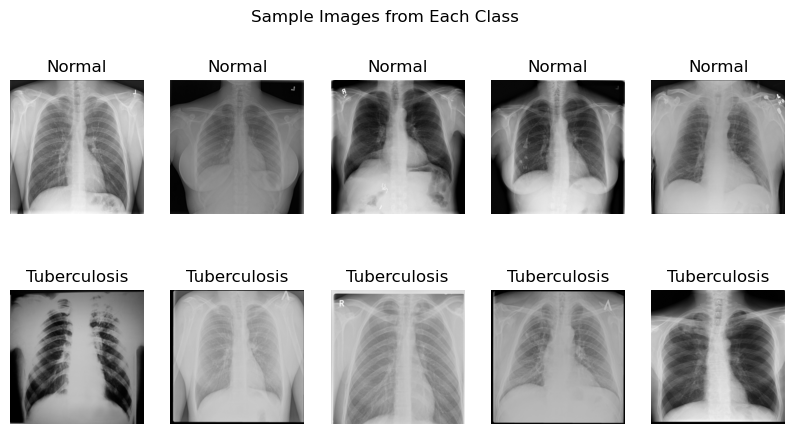

In [18]:
# Display sample images from each class
plt.figure(figsize=(10, 5))
for i in range(5):
    # Display Normal images
    plt.subplot(2, 5, i+1)
    plt.imshow(normal_images[random.randint(0, len(normal_images) - 1)])
    plt.title("Normal")
    plt.axis("off")

    # Display Tuberculosis images
    plt.subplot(2, 5, i+6)
    plt.imshow(tuberculosis_images[random.randint(0, len(tuberculosis_images) - 1)])
    plt.title("Tuberculosis")
    plt.axis("off")

plt.suptitle("Sample Images from Each Class")
plt.show()

In [19]:
def create_lenet_model(input_shape, num_classes=1):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(6, (5, 5), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (5, 5), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu')(x)
    x = layers.Dense(84, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # Output layer

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
input_shape = (256, 256, 3)  # Example input shape
num_classes = 1  # Example number of classes for binary classification
lenet_model = create_lenet_model(input_shape, num_classes)

# Print model summary
lenet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 252, 252, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     7,144,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,157,561 (27.30 MB)

 Trainable params: 7,157,561 (27.30 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# input_shape = (256, 256, 3)
# lenet_model = create_lenet_model(input_shape)

# Compile the model
lenet_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
# Print model summary
# lenet_model.summary()

In [21]:
history = lenet_model.fit(train_images, train_labels,
                          epochs=12,
                          batch_size=32,
                          validation_data=(test_images, test_labels))

Epoch 1/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.8581 - loss: 0.4351 - val_accuracy: 0.9595 - val_loss: 0.1231
Epoch 2/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 288ms/step - accuracy: 0.9666 - loss: 0.0946 - val_accuracy: 0.9702 - val_loss: 0.0808
Epoch 3/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 285ms/step - accuracy: 0.9767 - loss: 0.0717 - val_accuracy: 0.9393 - val_loss: 0.1647
Epoch 4/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 289ms/step - accuracy: 0.9641 - loss: 0.0962 - val_accuracy: 0.9500 - val_loss: 0.1230
Epoch 5/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 31s 292ms/step - accuracy: 0.9924 - loss: 0.0251 - val_accuracy: 0.9798 - val_loss: 0.0603
Epoch 6/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 31s 292ms/step - accuracy: 0.9936 - loss: 0.0201 - val_accuracy: 0.9774 - val_loss: 0.0811
Epoch 7/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 288ms/step - accuracy: 0.9866 - loss: 0.0364 - val_accuracy: 0.9655 - val_loss: 0.0940
Epoch 8/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 31s 293ms/step - accuracy: 0.9989 - loss: 0

In [22]:

test_loss, test_accuracy = lenet_model.evaluate(test_images, test_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9746 - loss: 0.1029
Test Loss: 0.09536555409431458
Test Accuracy: 0.9773809313774109


In [23]:
y_pred_probs = lenet_model.predict(test_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (test_labels > 0.5).astype(int)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [24]:
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       700
           1       0.92      0.94      0.93       140

    accuracy                           0.98       840
   macro avg       0.96      0.96      0.96       840
weighted avg       0.98      0.98      0.98       840

Confusion Matrix:
[[689  11]
 [  8 132]]


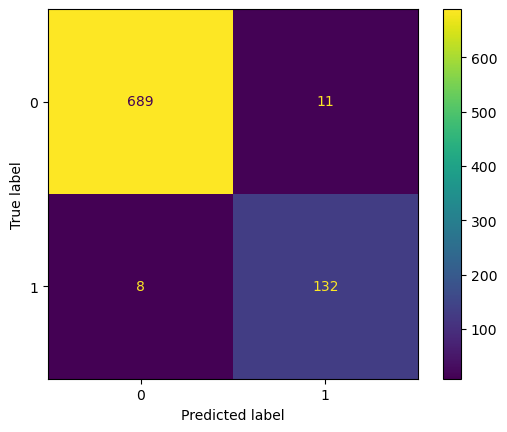

In [25]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(test_labels_binary, y_pred_binary)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [26]:
predictions = lenet_model.predict(test_images)

# Print the shape of the predictions array
print("Shape of predictions array:", predictions.shape)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Shape of predictions array: (840, 1)


In [27]:
import tensorflow.keras as K
last_conv_layer = next(x for x in lenet_model.layers[::-1] if isinstance(x, K.layers.Conv2D))
last_conv_layer.name

'conv2d_1'

In [28]:
spatial_maps =  lenet_model.get_layer('conv2d_1').output
print(spatial_maps)

<KerasTensor shape=(None, 122, 122, 16), dtype=float32, sparse=False, name=keras_tensor_3>


In [29]:
# get the output of the model
output_with_batch_dim = lenet_model.output
print(f"Model output includes batch dimension, has shape {output_with_batch_dim.shape}")
print(f"excluding the batch dimension, the output for all 14 categories of disease has shape {output_with_batch_dim[0].shape}")

Model output includes batch dimension, has shape (None, 1)
excluding the batch dimension, the output for all 14 categories of disease has shape (1,)


In [30]:
def GradCAM(model, image, interpolant=0.5, plot_results=True):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    # Preprocess image and make prediction using our model
    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)

    # Predict
    prediction = model.predict(img)
    prediction_idx = np.argmax(prediction)

    # Find the last convolutional layer
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
            break

    if last_conv_layer is None:
        raise ValueError("No convolutional layer found in the model.")

    # Create a model to extract feature maps and predictions
    gradient_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

    # Compute gradient of top predicted class
    with tf.GradientTape() as tape:
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)

    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(activation_map.numpy(), (original_img.shape[1], original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)

    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    if plot_results:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

In [31]:
def preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")
            image = image.resize((256, 256))
            image = np.array(image) / 255.0   # Normalize pixel values to [0, 1]
            images.append(image)
            labels.append(label)
    return images, labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


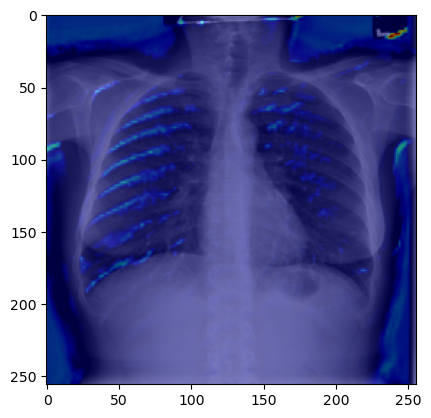

In [32]:
#Preprocess the test image
test_images, _ = preprocess_images("/Users/prajwal/Documents/TB_Chest_Radiography_Database/Normal", label=0)
test_img = test_images[158]

# Preprocessed image into GradCAM
GradCAM(lenet_model, test_img, plot_results=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

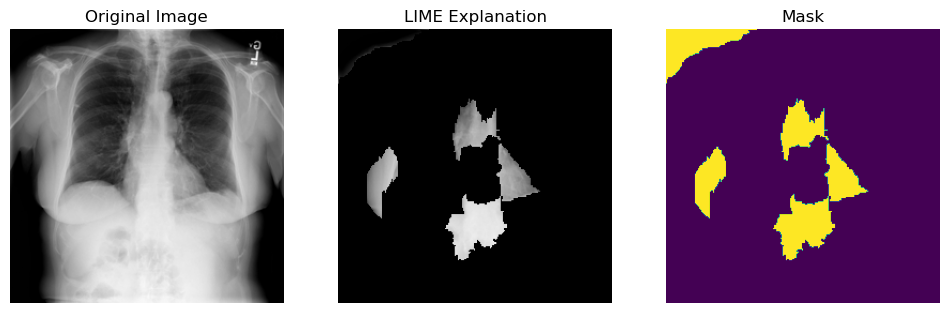

In [33]:
# Define a function to predict probabilities using the model
predict_fn = lambda x: lenet_model.predict(x)

explainer = lime_image.LimeImageExplainer()

# Select a sample image from the test set
sample_index = 155  # Index of the sample image in the test set
sample_image = test_images[sample_index]
sample_label = test_labels[sample_index]

# Explain the model's prediction for the sample image
explanation = explainer.explain_instance(sample_image, predict_fn, hide_color=0, num_samples=1000)

# Get the explanation image and mask
image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

# Plot the original image, masked image, and the mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image)
plt.title("LIME Explanation")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title("Mask")
plt.axis('off')

plt.show()

In [ ]:
# Print text explanation
print(explanation.local_exp[explanation.top_labels[0]])